In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from dataset_HR import AdSBHDataset
from model_HR_new import AdSBHNet
from constants import dreal, dcomplex

# Import dataset

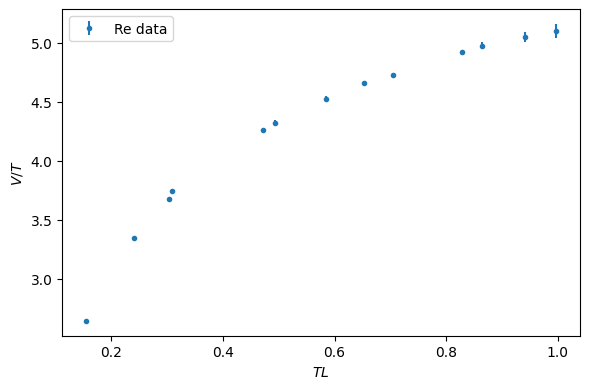

In [2]:
dataset = AdSBHDataset(file='1607latticeT338.txt')

# (optional) drop very large TL if you want to focus on TL<1, like before
mask_L = dataset.L < 1.0
L_all     = dataset.L[mask_L]
V_all     = dataset.V[mask_L]
sigma_all = dataset.sigma[mask_L]

# simple train/validation split (80/20)
N = len(L_all)
idx = torch.randperm(N)
n_train = int(0.8 * N)
train_idx = idx[:n_train]
val_idx   = idx[n_train:]

def subset(idx_tensor):
    return (L_all[idx_tensor], V_all[idx_tensor], sigma_all[idx_tensor])

L_train, V_train, sigma_train = subset(train_idx)
L_val,   V_val,   sigma_val   = subset(val_idx)

plt.figure(figsize=(6,4))
plt.errorbar(L_all.numpy(), V_all.real.numpy(),
             yerr=sigma_all.real.numpy(), fmt='.', label='Re data')
plt.xlabel(r'$T L$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()


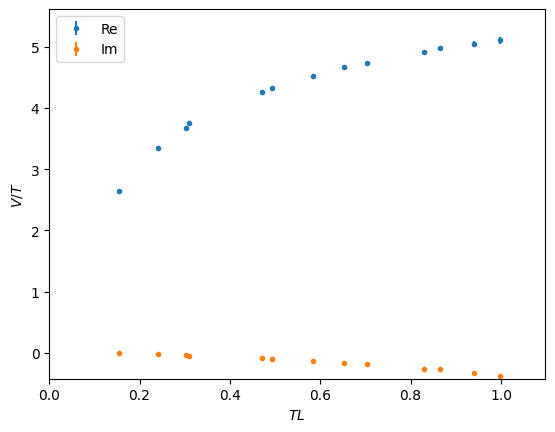

In [3]:
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

In [4]:
model = AdSBHNet(N=4, std=0.5)
device = L_all.device
model.to(device)

# start from AdS–BH but enforce a0=-b0<0 and modest magnitude
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    init_a0 = -0.3
    model.a[0] = init_a0
    model.b[0] = -init_a0
    model.logcoef.fill_(0.0)   # scale 1
    model.shift.fill_(0.0)     # shift 0

print("Initial parameters:")
print("  a =", model.a.detach().cpu().numpy())
print("  b =", model.b.detach().cpu().numpy())
print(f"  coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


Initial parameters:
  a = [-0.3  0.   0.   0. ]
  b = [0.3 0.  0.  0. ]
  coef = 1.000, shift = 0.000


# Helpers

In [5]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    dev, dt = model.a.device, model.a.dtype
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


def V_of_L_interp_real(model, L_query,
                       zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7, eps=1e-12):
    dev, dt = model.a.device, model.a.dtype
    Lq = torch.as_tensor(L_query, dtype=dt, device=dev).reshape(-1)

    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)

    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]

    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    Lm, Vm = Lc[keep], Vc[keep]

    if Lm.numel() < 2:
        Lm, Vm = Lc, Vc

    pos = torch.searchsorted(Lm, Lq, right=True)
    i0 = (pos-1).clamp(0, Lm.numel()-2)
    i1 = i0+1
    x0, x1 = Lm[i0], Lm[i1]
    y0, y1 = Vm[i0], Vm[i1]

    w     = (Lq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1-y0)

    mL = (Vm[1]-Vm[0])   / (Lm[1]-Lm[0]   + eps)
    mR = (Vm[-1]-Vm[-2]) / (Lm[-1]-Lm[-2] + eps)

    v_left  = Vm[0]  + mL*(Lq - Lm[0])
    v_right = Vm[-1] + mR*(Lq - Lm[-1])

    v = torch.where(Lq <  Lm[0],  v_left,  v_lin)
    v = torch.where(Lq >  Lm[-1], v_right, v)

    return v, (Lm[0].detach(), Lm[-1].detach())


def smoothness_C2(val_fn, z):
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()


def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995, dtype=model.a.dtype, device=model.a.device)

    f0   = model.eval_f(z0)
    g0   = model.eval_g(z0)
    fhor = model.eval_f(zh)

    def _r2(t, target):
        if torch.is_complex(t):
            return (t.real - target)**2 + t.imag**2
        else:
            return (t - target)**2

    return _r2(f0, 1.0) + _r2(g0, 1.0) + _r2(fhor, 0.0)

def swallowtail_reg(current_model, z_grid, L0_ref, V0_ref,
                    alpha_L=1.0, alpha_V=0.3):
    """
    Penalize deviations of the real parametric curve (L(z*), V(z*)) from
    the reference AdS–BH swallowtail.

    alpha_L: relative weight on matching L(z*)
    alpha_V: relative weight on matching V(z*)
    """
    Lc = current_model.integrate_L(z_grid).real
    Vc = current_model.integrate_V(z_grid).real

    loss_L = ((Lc - L0_ref)**2).mean()
    loss_V = ((Vc - V0_ref)**2).mean()

    return alpha_L * loss_L + alpha_V * loss_V



# Initialization 

In [6]:
from sklearn.linear_model import LinearRegression

with torch.no_grad():
    Lm, Vm = connected_branch(model)
    Ld = L_train.to(device=Lm.device, dtype=Lm.dtype)
    Vd = V_train.real.to(device=Lm.device, dtype=Lm.dtype)

    mask = (Ld >= Lm[0]) & (Ld <= Lm[-1])
    L_fit = Ld[mask]
    Y_fit = Vd[mask]

    # model V at those L (via interpolation)
    def _interp_1d(x, y, xq, eps=1e-12):
        dt, dev = x.dtype, x.device
        xq = torch.as_tensor(xq, dtype=dt, device=dev).reshape(-1)
        pos = torch.searchsorted(x, xq, right=True)
        i0 = (pos-1).clamp(0, x.numel()-2); i1 = i0+1
        x0, x1 = x[i0], x[i1]; y0, y1 = y[i0], y[i1]
        w  = (xq - x0) / (x1 - x0 + eps)
        v_lin = y0 + w*(y1-y0)
        mL = (y[1]-y[0])/(x[1]-x[0]+eps)
        mR = (y[-1]-y[-2])/(x[-1]-x[-2]+eps)
        v_left  = y[0]  + mL*(xq - x[0])
        v_right = y[-1] + mR*(xq - x[-1])
        v = torch.where(xq <  x[0],  v_left,  v_lin)
        v = torch.where(xq >  x[-1], v_right, v)
        return v

    X_fit = _interp_1d(Lm, Vm, L_fit) / model.logcoef.exp()

    fit = LinearRegression().fit(X_fit.cpu().numpy().reshape(-1,1),
                                 Y_fit.cpu().numpy())
    slope = max(float(fit.coef_[0]), 1e-12)
    shift = float(fit.intercept_)

    model.logcoef = nn.Parameter(torch.tensor(np.log(slope),
                                              dtype=model.a.dtype,
                                              device=model.a.device))
    model.shift   = nn.Parameter(torch.tensor(shift,
                                              dtype=model.a.dtype,
                                              device=model.a.device))

print(f"LS init: coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


LS init: coef = 0.255, shift = 5.068


In [7]:
device = model.a.device
dtype  = model.a.dtype
eps    = 1e-12

baseline = AdSBHNet(N=4, std=0.4).to(device)

with torch.no_grad():
    baseline.a.zero_()
    baseline.b.zero_()
    baseline.logcoef.zero_()  # exp(0)=1
    baseline.shift.zero_()

# grid in z* to define the reference swallowtail
z_sw = torch.linspace(0.02, 0.995, 256, dtype=dtype, device=device)

with torch.no_grad():
    L0_sw = baseline.integrate_L(z_sw).real.detach()
    V0_sw = baseline.integrate_V(z_sw).real.detach()

# we want L0_sw, V0_sw as fixed Tensors on the right device/dtype
L0_sw = L0_sw.to(device=device, dtype=dtype)
V0_sw = V0_sw.to(device=device, dtype=dtype)

print("Reference swallowtail ready: ",
      "L0 range =", (float(L0_sw.min()), float(L0_sw.max())),
      "V0 range =", (float(V0_sw.min()), float(V0_sw.max())))


Reference swallowtail ready:  L0 range = (0.0005569208729975221, 0.3449278591389672) V0 range = (-310.0544415276272, -5.140535657926396)


# Loss function

In [8]:
eps = 1e-12

def compute_loss_real(model, Lb, Vb, sb,
                 lam_a_L2=1e-4, lam_b_L2=2e-4,
                 lam_a_C2=9e-4, lam_b_C2=7e-4,
                 lam_phy=3e-3,
                 tail_L_frac=0.7, tail_factor=3.0):
    """
    Real-branch loss:
      - data term: Re V only, via V_of_L_interp_real
      - regularisers: L2(a,b) + smoothness + UV/horizon
      - extra weight for points at large L (tail_factor)
    """
    dev = model.a.device
    dt  = model.a.dtype

    Lb = Lb.to(dev, dt)
    Vb = Vb.to(dev)
    sb = sb.to(dev)

    # --- model prediction on real connected branch ---
    V_core, (Lmin_sup, Lmax_sup) = V_of_L_interp_real(model, Lb, zs_num=4000)
    mask = (Lb >= Lmin_sup) & (Lb <= Lmax_sup)
    if mask.sum() == 0:
        return None, None

    V_pred = V_core[mask] + model.shift        # real
    r_re   = V_pred - Vb.real[mask]            # real residual

    # --- weights ---
    w_re = torch.clamp(1.0/(sb.real[mask]**2 + eps), max=1e6)

    # L-weight (bias to larger L)
    L_norm = (Lb[mask] / L_all.max()).clamp_min(0.0)
    wL = L_norm.pow(2.0)    # exponent 2.0 instead of 1.5

    # extra boost for "tail" region
    #tail_mask = (L_norm > tail_L_frac)
    #tail_boost = torch.ones_like(wL)
    #tail_boost[tail_mask] = tail_factor

    w_eff = w_re * wL #* tail_boost

    loss_re = (w_eff * r_re**2).mean()

    z_reg = torch.linspace(1e-3, 0.99, 220, dtype=dt, device=dev)

    reg_L2  = lam_a_L2*(model.a.real**2).sum() + lam_b_L2*(model.b.real**2).sum()
    reg_C2  = lam_a_C2*smoothness_C2(model.eval_a, z_reg) \
            + lam_b_C2*smoothness_C2(model.eval_b, z_reg)
    reg_phy = lam_phy * uv_horizon_penalty(model)

    loss = loss_re + reg_L2 + reg_C2 + reg_phy

    components = {
        'mask': mask,
        'loss_re': loss_re.detach(),
        'reg_L2': reg_L2.detach(),
        'reg_C2': reg_C2.detach(),
        'reg_phy': reg_phy.detach(),
    }
    return loss, components


**Loss version 2 (maybe do not use)**

In [ ]:
eps = 1e-12

@torch.no_grad()
def enforce_ab_constraints(model):
    """
    Force a[0] = -|a0| < 0 and b[0] = -a[0].
    Returns the enforced a0 value (float).
    """
    a0 = -model.a[0].abs()
    model.a[0].copy_(a0)
    model.b[0].copy_(-a0)
    return float(a0.item())


def compute_loss_real(model, Lb, Vb, sb,
                      lam_a_L2=1e-4, lam_b_L2=1e-5,
                      lam_a_C2=3e-4, lam_b_C2=1e-4,
                      lam_phy=3e-3,
                      L_power=3.0,
                      L_swallowtail_min=0.34,
                      swallowtail_w=4.0):
    """
    Real-part loss on the connected branch with:
      - chi^2 on Re V
      - smoothness/UV/horizon regularisers
      - explicit swallowtail/turning-point penalty to push L_max >= L_swallowtail_min
      - projection enforcing a[0] = -b[0] < 0 each call
    Returns loss tensor or (None, {...}) if no in-support points, plus diagnostics.
    """
    # enforce constraint before computing anything
    enforced_a0 = enforce_ab_constraints(model)

    dev, dt = model.a.device, model.a.dtype
    Lb = Lb.to(dev, dtype=dt)
    Vb = Vb.to(dev)
    sb = sb.to(dev)

    V_core, (Lmin, Lmax) = V_of_L_interp_real(model, Lb, zs_num=4000)
    mask = (Lb >= Lmin) & (Lb <= Lmax)
    if mask.sum() == 0:
        return None, {'mask': mask, 'Lmax': float(Lmax.item())}

    V_pred = V_core[mask] + model.shift       # real
    r_re   = V_pred - Vb.real[mask]

    w_re = 1.0 / (sb.real[mask]**2 + eps)
    wL   = (Lb[mask] / L_all.max()).clamp_min(0).pow(L_power)

    loss_re = (w_re * wL * r_re**2).mean()

    # regularizers
    z_reg = torch.linspace(1e-3, 0.99, 220, dtype=dt, device=dev)
    reg_L2  = lam_a_L2*(model.a.real**2).sum() + lam_b_L2*(model.b.real**2).sum()
    reg_C2  = lam_a_C2*smoothness_C2(model.eval_a, z_reg)             + lam_b_C2*smoothness_C2(model.eval_b, z_reg)
    reg_phy = lam_phy * uv_horizon_penalty(model)

    loss = loss_re + reg_L2 + reg_C2 + reg_phy

    # swallowtail / coverage penalties
    Lmax_model = float(Lmax.item())
    Lmax_data  = float(L_all.max().item())
    if Lmax_model < Lmax_data:
        shortfall = (Lmax_data - Lmax_model) / max(Lmax_data, 1e-6)
        loss = loss + 2.0 * (shortfall**2)
    if Lmax_model < L_swallowtail_min:
        gap = (L_swallowtail_min - Lmax_model) / L_swallowtail_min
        loss = loss + swallowtail_w * (gap**2)

    return loss, {'mask': mask, 'loss_re': loss_re.detach(), 'Lmax': Lmax_model, 'a0': enforced_a0}


# Training

In [10]:
device = model.a.device
dt     = model.a.dtype
eps    = 1e-12

L_all     = dataset.L.to(device=device, dtype=dt)
V_all     = dataset.V.to(device=device, dtype=torch.cdouble)  # keep complex
sigma_all = dataset.sigma.to(device=device, dtype=torch.cdouble)

N_tot  = L_all.shape[0]
perm   = torch.randperm(N_tot, device=device)
n_val  = max(4, int(0.2 * N_tot))

idx_val   = perm[:n_val]
idx_train = perm[n_val:]

L_train, V_train, sigma_train = L_all[idx_train], V_all[idx_train], sigma_all[idx_train]
L_val,   V_val,   sigma_val   = L_all[idx_val],   V_all[idx_val],   sigma_all[idx_val]

torch.set_grad_enabled(True)

# small random kick so grads aren’t dead
with torch.no_grad():
    if torch.allclose(model.a, torch.zeros_like(model.a)):
        model.a.normal_(0.0, 5e-4)
    if torch.allclose(model.b, torch.zeros_like(model.b)):
        model.b.normal_(0.0, 5e-4)

train_ds     = torch.utils.data.TensorDataset(L_train, V_train, sigma_train)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)

opt = torch.optim.AdamW([
    {'params': [model.a],       'lr': 1.5e-2, 'weight_decay': 5e-5},
    {'params': [model.b],       'lr': 3.0e-2, 'weight_decay': 2e-5},  
    {'params': [model.shift],   'lr': 1.0e-2, 'weight_decay': 0.0},
    {'params': [model.logcoef], 'lr': 2.0e-3, 'weight_decay': 0.0},
], betas=(0.9, 0.999))

EPOCHS = 150
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=2e-4)

a_hist, b_hist = [], []
train_loss_hist, val_loss_hist = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    n_batches = 0

    for Lb, Vb, sb in train_loader:
        opt.zero_grad()
        out = compute_loss_real(model, Lb, Vb, sb)
        loss_core, info = out
        if loss_core is None:
            continue

        loss_core.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running += float(loss_core.item())
        n_batches += 1

    sched.step()
    train_loss = running / max(n_batches, 1)

    #  validation: same loss but without regularizers (just data term) 
    model.eval()
    with torch.no_grad():
        loss_val = 0.0
        n_val_batches = 0
        V_core_val, (Lmin_val, Lmax_val) = V_of_L_interp_real(model, L_val)
        mask_val = (L_val >= Lmin_val) & (L_val <= Lmax_val)
        if mask_val.sum() > 0:
            V_pred_val = V_core_val[mask_val] + model.shift
            r_val = V_pred_val - V_val.real[mask_val]
            w_re_val = 1.0 / (sigma_val.real[mask_val]**2 + eps)
            wL_val   = (L_val[mask_val] / L_all.max()).clamp_min(0).pow(3.0)
            loss_val = float((w_re_val*wL_val*r_val**2).mean().item())
            n_val_batches = 1

    a_hist.append(model.a.detach().cpu().numpy().copy())
    b_hist.append(model.b.detach().cpu().numpy().copy())
    train_loss_hist.append(train_loss)
    val_loss_hist.append(loss_val)

    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | train_loss={train_loss:.4e} | "
              f"val_loss={loss_val:.4e} | shift={model.shift.item():.3f} | "
              f"coef={model.logcoef.exp().item():.3e}")

#  post-training LS recalibration of scale + shift 
with torch.no_grad():
    # real connected branch for this trained model
    Lm, Vm_full = connected_branch(model)   # your helper; returns real tensors

    # use real data only where model has coverage
    mask_cov = (L_all >= Lm[0]) & (L_all <= Lm[-1])
    L_fit = L_all[mask_cov]
    Y_fit = V_all.real[mask_cov]

    X_fit_full = _interp_1d(Lm, Vm_full, L_fit)     # FULL V at those L

    # remove current scale before LS so new slope becomes logcoef
    X_fit = X_fit_full / model.logcoef.exp()

    x_np = X_fit.cpu().numpy().reshape(-1, 1)
    y_np = Y_fit.cpu().numpy()

    from sklearn.linear_model import LinearRegression
    fit = LinearRegression().fit(x_np, y_np)
    slope = max(float(fit.coef_[0]), 1e-12)
    shift = float(fit.intercept_)

    model.logcoef = nn.Parameter(torch.tensor(np.log(slope), dtype=dt, device=device))
    model.shift   = nn.Parameter(torch.tensor(shift, dtype=dt, device=device))

print(f"After post-training LS: coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


epoch   1 | train_loss=5.8095e+02 | val_loss=0.0000e+00 | shift=3.336 | coef=1.000e-12
epoch  10 | train_loss=4.5464e+02 | val_loss=0.0000e+00 | shift=3.247 | coef=1.000e-12
epoch  20 | train_loss=3.6711e+02 | val_loss=0.0000e+00 | shift=3.149 | coef=1.000e-12
epoch  30 | train_loss=3.3242e+02 | val_loss=0.0000e+00 | shift=3.055 | coef=1.000e-12
epoch  40 | train_loss=3.3325e+02 | val_loss=0.0000e+00 | shift=3.018 | coef=1.000e-12
epoch  50 | train_loss=3.3143e+02 | val_loss=0.0000e+00 | shift=3.054 | coef=1.000e-12
epoch  60 | train_loss=3.3126e+02 | val_loss=0.0000e+00 | shift=3.040 | coef=1.000e-12
epoch  70 | train_loss=3.3127e+02 | val_loss=0.0000e+00 | shift=3.046 | coef=1.001e-12
epoch  80 | train_loss=3.3125e+02 | val_loss=0.0000e+00 | shift=3.045 | coef=1.001e-12
epoch  90 | train_loss=3.3135e+02 | val_loss=0.0000e+00 | shift=3.044 | coef=1.001e-12
epoch 100 | train_loss=3.3132e+02 | val_loss=0.0000e+00 | shift=3.044 | coef=1.002e-12
epoch 110 | train_loss=3.3121e+02 | val_los

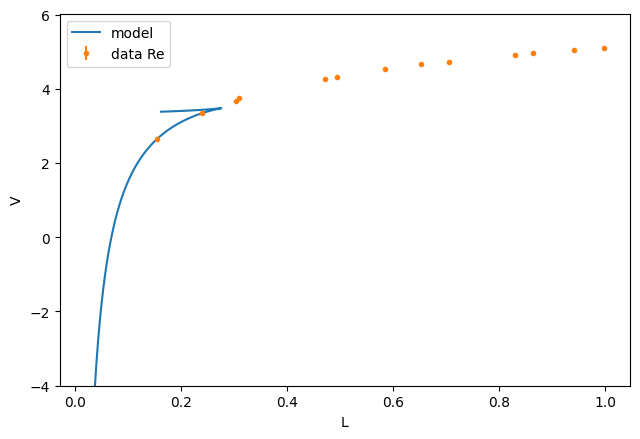

In [11]:
with torch.no_grad():
    zs = torch.linspace(0.05, 0.99, 800, dtype=dtype, device=device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift

plt.figure(figsize=(6.5,4.5))
plt.plot(Lc.cpu(), Vc.cpu(), label="model")
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
             yerr=dataset.sigma.real.cpu(), fmt='.', label='data Re')
plt.ylim(-4, None)
plt.xlabel("L"); plt.ylabel("V"); plt.legend(); plt.tight_layout()


**Visualization**

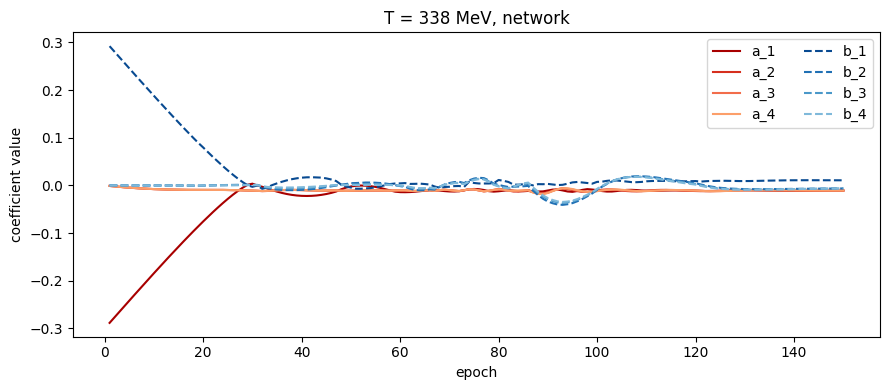

In [12]:
a_arr = np.stack(a_hist)   # shape (EPOCHS, N)
b_arr = np.stack(b_hist)   # shape (EPOCHS, N)
epochs = np.arange(1, len(a_hist)+1)

n_a = a_arr.shape[1]
n_b = b_arr.shape[1]

# palettes: darkest for index 0, lightest for highest index
warm = plt.cm.OrRd(np.linspace(0.9, 0.45, n_a))   # a: warm colors
cold = plt.cm.Blues(np.linspace(0.9, 0.45, n_b))  # b: cool colors

plt.figure(figsize=(9,4))
for i in range(n_a):
    plt.plot(epochs, a_arr[:, i], color=warm[i], label=f"a_{i+1}")
for i in range(n_b):
    plt.plot(epochs, b_arr[:, i], color=cold[i], linestyle='--', label=f"b_{i+1}")
plt.xlabel("epoch")
plt.ylabel("coefficient value")
plt.legend(ncol=2)
plt.title("T = 338 MeV, network")
plt.tight_layout()


# Export the results

In [13]:
@torch.no_grad()
def print_ab(model):
    a = model.a.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Plain readable print
    print("a:", ", ".join([f"a{i} = {a[i]:.10g}" for i in range(len(a))]))
    print("b:", ", ".join([f"b{i} = {b[i]:.10g}" for i in range(len(b))]))

    # Mathematica-friendly rows
    print("\n(* Mathematica lists *)")
    print("{", ", ".join([f"{x:.17g}" for x in a]), "},  (* a0..aN *)")
    print("{", ", ".join([f"{x:.17g}" for x in b]), "},  (* b0..bN *)")

print_ab(model)
print(model.logcoef.exp().item(), model.shift.item())

a: a0 = -0.01072298924, a1 = -0.01092523283, a2 = -0.01084652879, a3 = -0.01071786431
b: b0 = 0.0107205142, b1 = -0.006335773982, b2 = -0.006446012121, b3 = -0.006458517206

(* Mathematica lists *)
{ -0.010722989238233992, -0.010925232833918445, -0.010846528789835269, -0.010717864313101646 },  (* a0..aN *)
{ 0.010720514196572394, -0.0063357739816327962, -0.0064460121208197814, -0.0064585172060853055 },  (* b0..bN *)
0.22416155164353 4.76363483634741
